# Exploring Dandiset 000690: Allen Institute Openscope - Vision2Hippocampus project

**Disclaimer:** This notebook was generated by an AI assistant (Minicline) and has not been fully verified by human experts. Please exercise caution when interpreting the code or results.

## Dandiset Overview

This notebook explores Dandiset [000690](https://dandiarchive.org/dandiset/000690), titled "Allen Institute Openscope - Vision2Hippocampus project".

**Description:** Extensive research shows that visual cortical neurons respond to specific stimuli, e.g. the primary visual cortical neurons respond to bars of light with specific orientation. In contrast, the hippocampal neurons are thought to encode not specific stimuli but instead represent abstract concepts such as space, time and events. How is this abstraction computed in the mouse brain? Specifically, how does the representation of simple visual stimuli evolve from the thalamus, which is a synapse away from the retina, through primary visual cortex, higher order visual areas and all the way to hippocampus, that is farthest removed from the retina?

The current OpenScope project aims to understand how the neural representations of simple and natural stimuli evolve from the LGN through V1, and most hippocampal regions, as well as some of the frontal areas. Stimuli involved simple visual motion (bars of light) and complex movies (eagles, squirrels).

**Keywords:** mouse, neuropixel, extracellular electrophysiology, neocortex, hippocampus, Entorhinal cortex, excitatory, inhibitory, vision, movies

**Data Types:** ElectricalSeries, LFP, ProcessingModule, Units

## Notebook Summary

This notebook demonstrates how to:
1. Connect to the DANDI Archive and access the metadata for Dandiset 000690.
2. List the assets (files) within the Dandiset.
3. Load a specific NWB file containing extracellular electrophysiology data (LFP) from one probe.
4. Summarize the contents and metadata of the NWB file.
5. Load and visualize a subset of the LFP data and associated electrode information.

## Required Packages

This notebook requires the following Python packages:

*   `dandi` (for interacting with the DANDI Archive)
*   `pynwb` (for reading NWB files)
*   `h5py` (dependency for pynwb, for HDF5 interaction)
*   `remfile` (for streaming remote HDF5 files)
*   `numpy` (for numerical operations)
*   `matplotlib` (for plotting)
*   `pandas` (for handling tabular data like electrode information)
*   `seaborn` (for enhanced plotting styles)

It is assumed that these packages are already installed in your environment.

## 1. Loading Dandiset Information from DANDI Archive

In [1]:
from dandi.dandiapi import DandiAPIClient
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pynwb
import h5py
import remfile
import seaborn as sns

# Set seaborn theme for plots (except images)
sns.set_theme()

In [2]:
# Connect to DANDI archive
try:
    client = DandiAPIClient()
    dandiset = client.get_dandiset("000690", "draft") # Use draft version

    # Print basic information about the Dandiset
    metadata = dandiset.get_raw_metadata()
    print(f"Dandiset name: {metadata['name']}")
    print(f"Dandiset URL: {metadata.get('url', 'URL not found in metadata')}") # Handle cases where URL might be missing
    print(f"Dandiset description: {metadata.get('description', 'Description not found')[:200]}...") # Print first 200 chars

    # List the assets in the Dandiset
    assets = list(dandiset.get_assets())
    print(f"\nFound {len(assets)} assets in the dataset.")

    # Filter for NWB assets and print first 5
    nwb_assets = [a for a in assets if a.path.endswith('.nwb')]
    print(f"Found {len(nwb_assets)} NWB assets.")
    print("\nFirst 5 NWB assets:")
    for asset in nwb_assets[:5]:
        print(f"- {asset.path} (ID: {asset.identifier}, Size: {asset.size / (1024**3):.2f} GB)")

except Exception as e:
    print(f"Error connecting to DANDI or fetching assets: {e}")
    print("Please ensure you have an internet connection and the 'dandi' package is installed.")
    # Assign empty list if assets cannot be fetched
    nwb_assets = []

Dandiset name: Allen Institute Openscope - Vision2Hippocampus project
Dandiset URL: https://dandiarchive.org/dandiset/000690/draft
Dandiset description: Extensive research shows that visual cortical neurons respond to specific stimuli, e.g. the primary visual cortical neurons respond to bars of light with specific orientation. In contrast, the hippoca...

Found 156 assets in the dataset.
Found 156 NWB assets.

First 5 NWB assets:
- sub-692077/sub-692077_ses-1300222049_probe-4_ecephys.nwb (ID: b0ea16d5-42eb-4b56-87cc-7d7b7efab4db, Size: 1.57 GB)
- sub-692077/sub-692077_ses-1300222049_probe-3_ecephys.nwb (ID: e0ad1921-75f1-43ed-aa86-8e1a45a9f49d, Size: 1.66 GB)
- sub-692077/sub-692077_ses-1300222049_probe-2_ecephys.nwb (ID: 97712120-158d-492a-ae21-61515335bc18, Size: 1.53 GB)
- sub-692077/sub-692077_ses-1300222049_probe-0_ecephys.nwb (ID: de12ccea-83a7-4d7f-937c-4c02e4d3bf44, Size: 1.63 GB)
- sub-692077/sub-692077_ses-1300222049.nwb (ID: 8ae65111-a130-47fc-a108-55e695374739, Size: 2.28 G

## 2. Loading a Specific NWB File

We will now load one of the NWB files containing LFP data from a specific probe. We'll use the file:

`sub-692072/sub-692072_ses-1298465622_probe-0_ecephys.nwb`

The Asset ID for this file is `ba8760f9-91fe-4c1c-97e6-590bed6a783b`. We can construct the download URL using this ID.

The NWB file format allows for streaming data, so we don't need to download the entire file (which can be large) to start exploring it. We will use `remfile` and `h5py` to open the remote file.

In [3]:
# Define the specific NWB file URL we want to load
# (Asset ID: ba8760f9-91fe-4c1c-97e6-590bed6a783b)
nwb_file_url = "https://api.dandiarchive.org/api/assets/ba8760f9-91fe-4c1c-97e6-590bed6a783b/download/"
asset_id = "ba8760f9-91fe-4c1c-97e6-590bed6a783b"

print(f"Loading NWB file from: {nwb_file_url}")

# Load the NWB file using remfile for remote access
nwb = None
io = None
h5_file = None
remote_file = None
try:
    remote_file = remfile.File(nwb_file_url)
    h5_file = h5py.File(remote_file, 'r') # Open in read mode
    io = pynwb.NWBHDF5IO(file=h5_file, mode='r', load_namespaces=True) # Specify read mode
    nwb = io.read()
    print("\nNWB file loaded successfully.")
    # Print some basic info from the loaded file
    print(f"  Identifier: {nwb.identifier}")
    print(f"  Session Description: {nwb.session_description}")
    print(f"  Session Start Time: {nwb.session_start_time}")
    print(f"  Subject ID: {nwb.subject.subject_id if nwb.subject else 'N/A'}")
    print(f"  Subject Species: {nwb.subject.species if nwb.subject else 'N/A'}")

except Exception as e:
    print(f"\nError loading NWB file: {e}")
    print("This might be due to network issues or file format inconsistencies.")
    # Ensure variables are None if loading fails
    nwb = None
    io = None
    h5_file = None # Close HDF5 file if open
    remote_file = None # Close remote file if open

Loading NWB file from: https://api.dandiarchive.org/api/assets/ba8760f9-91fe-4c1c-97e6-590bed6a783b/download/


/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."



NWB file loaded successfully.
  Identifier: 0
  Session Description: LFP data and associated info for one probe
  Session Start Time: 2023-09-21 00:00:00-07:00
  Subject ID: 692072
  Subject Species: Mus musculus


You can also explore this specific NWB file interactively using Neurosift:
[https://neurosift.app/nwb?url={nwb_file_url}&dandisetId=000690&dandisetVersion=draft](https://neurosift.app/nwb?url={nwb_file_url}&dandisetId=000690&dandisetVersion=draft)

## 3. Summarizing NWB File Contents

Let's explore the structure of the loaded NWB file. NWB files organize data hierarchically. Key information is often found in acquisition, processing modules, electrodes table, and subject information.

In [4]:
if nwb:
    print("Key components of the NWB file:")

    # Acquisition Data
    print("\n--- Acquisition ---")
    if nwb.acquisition:
        for name, data_object in nwb.acquisition.items():
            print(f"  {name}: {type(data_object)}")
            if isinstance(data_object, pynwb.ecephys.LFP):
                for series_name, series_obj in data_object.electrical_series.items():
                    print(f"    {series_name}: {type(series_obj)}")
                    print(f"      Data shape: {series_obj.data.shape}")
                    print(f"      Timestamps shape: {series_obj.timestamps.shape}")
                    print(f"      Unit: {series_obj.unit}")
                    # Display electrode table info if linked
                    if series_obj.electrodes:
                        print(f"      Linked to {len(series_obj.electrodes)} electrodes in the electrodes table.")
            # Print info for other potential acquisition types if needed
    else:
        print("  No acquisition data found.")

    # Electrodes Table
    print("\n--- Electrodes Table ---")
    if nwb.electrodes:
        print(f"  Number of electrodes: {len(nwb.electrodes)}")
        # Display as pandas DataFrame
        electrodes_df = nwb.electrodes.to_dataframe()
        print("  First 5 rows of the electrodes table:")
        # Limit columns shown for brevity
        cols_to_show = ['location', 'group_name', 'probe_vertical_position', 'probe_horizontal_position', 'probe_id', 'valid_data']
        print(electrodes_df[cols_to_show].head())
    else:
        print("  No electrodes table found.")

    # Subject Information
    print("\n--- Subject ---")
    if nwb.subject:
        print(f"  Subject ID: {nwb.subject.subject_id}")
        print(f"  Species: {nwb.subject.species}")
        print(f"  Sex: {nwb.subject.sex}")
        print(f"  Age: {nwb.subject.age}")
        print(f"  Genotype: {nwb.subject.genotype}")
    else:
        print("  No subject information found.")

else:
    print("NWB file was not loaded successfully, cannot summarize contents.")

Key components of the NWB file:

--- Acquisition ---
  probe_0_lfp: <class 'pynwb.ecephys.LFP'>
    probe_0_lfp_data: <class 'pynwb.ecephys.ElectricalSeries'>
      Data shape: (10117092, 95)
      Timestamps shape: (10117092,)
      Unit: volts
      Linked to 95 electrodes in the electrodes table.
  probe_0_lfp_data: <class 'pynwb.ecephys.ElectricalSeries'>

--- Electrodes Table ---
  Number of electrodes: 95
  First 5 rows of the electrodes table:
   location group_name  probe_vertical_position  probe_horizontal_position  \
id                                                                           
2        PF     probeA                       40                         59   
6        TH     probeA                       80                         59   
10       TH     probeA                      120                         59   
14       TH     probeA                      160                         59   
18       LP     probeA                      200                         59   

## 4. Visualizing LFP Data

Now, let's load and visualize some of the Local Field Potential (LFP) data. This file contains LFP data under `acquisition['probe_0_lfp']['probe_0_lfp_data']`.

The full LFP dataset is very large (`(10117092, 95)`), representing many time points across 95 channels. Loading the entire dataset into memory might not be feasible or necessary for an initial exploration. We will load a small subset of the data:

*   **Time:** A 2-second window (assuming a sampling rate of ~625 Hz based on group info, this is about 1250 samples).
*   **Channels:** A few selected channels.

We need the timestamps and the corresponding data for this window and these channels.

Inferred sampling rate from timestamps: 1250.00 Hz

Loading LFP data from index 100000 to 102500 (2500 samples)
Loading channel indices: [0, 10, 20, 30, 40] (Corresponding Electrode IDs: [   location                                              group group_name  \
id                                                                          
2        PF  probeA abc.EcephysElectrodeGroup at 0x14004755...     probeA   

    probe_vertical_position  probe_horizontal_position  probe_id  local_index  \
id                                                                              
2                        40                         59         0            2   

    valid_data       x       y       z  imp  \
id                                            
2         True  7465.0  3406.0  6685.0  NaN   

                                            filtering  
id                                                     
2   AP band: 500 Hz high-pass; LFP band: 1000 Hz l...  ,    location              

Loaded Timestamps shape: (2500,)
Loaded LFP Data shape: (2500, 5)


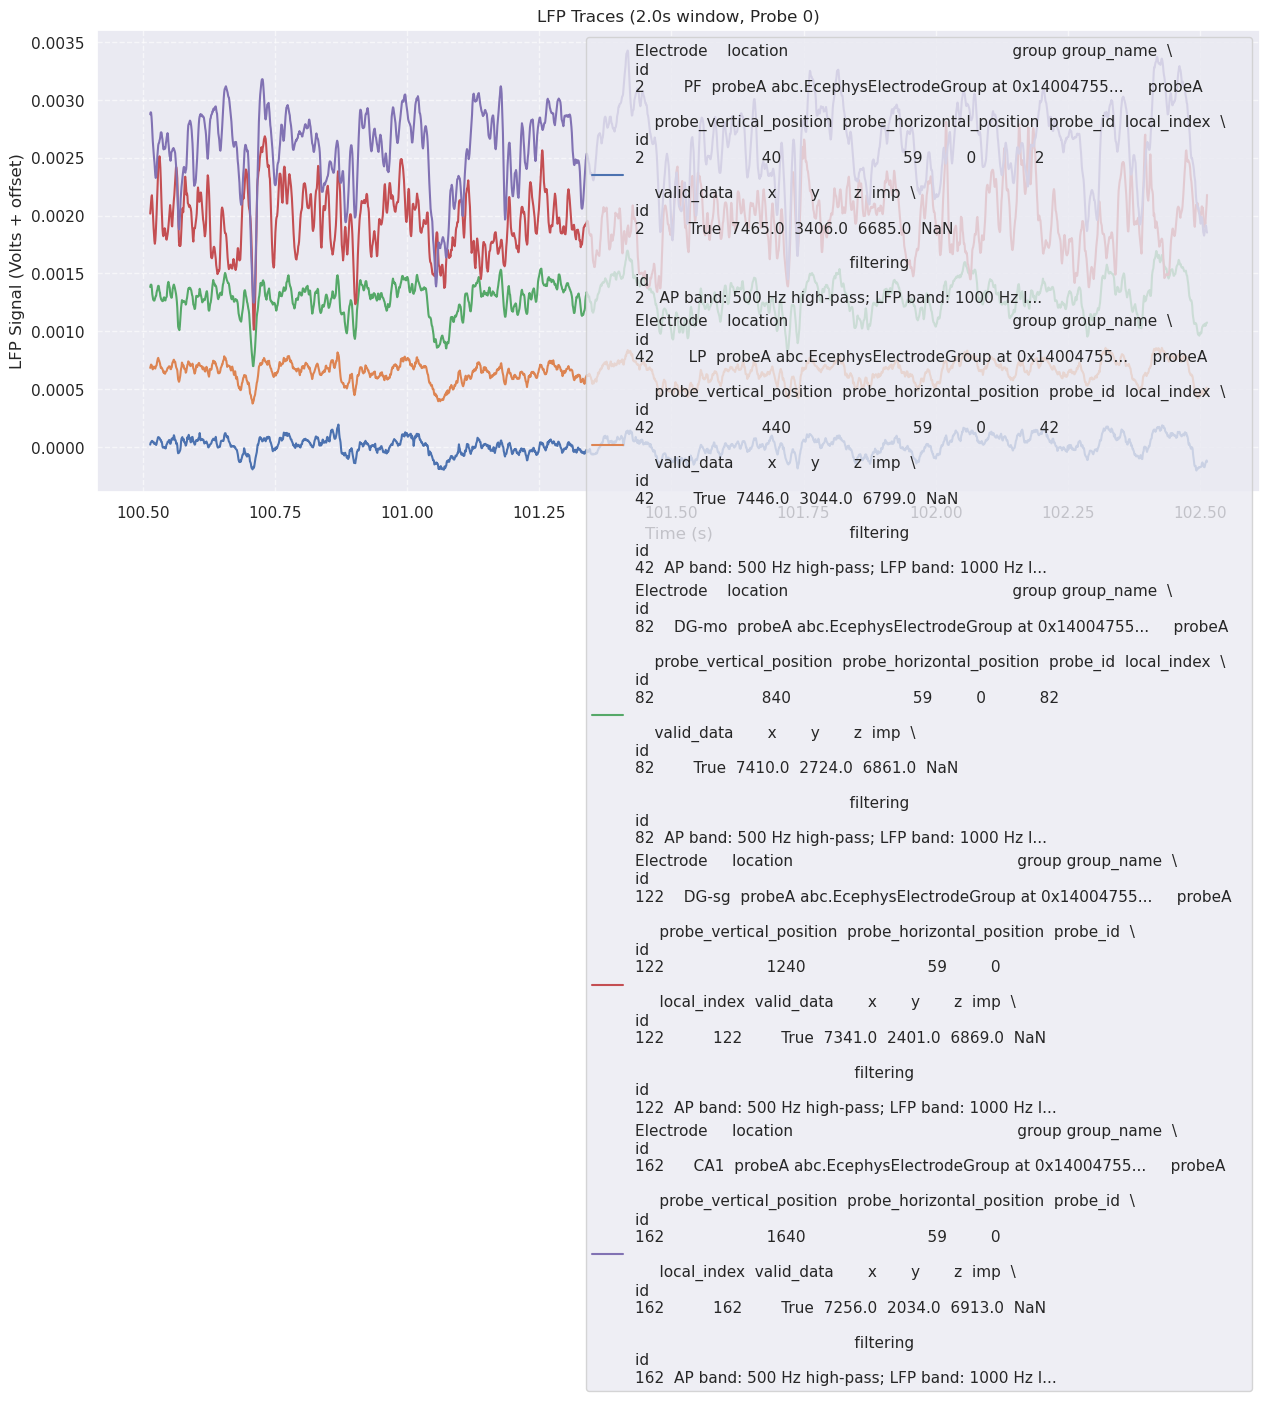

In [5]:
if nwb and 'probe_0_lfp' in nwb.acquisition:
    try:
        lfp_series = nwb.acquisition['probe_0_lfp']['probe_0_lfp_data']
        electrodes_df = nwb.electrodes.to_dataframe() if nwb.electrodes else pd.DataFrame() # Get electrodes df again if needed

        # --- Determine Sampling Rate ---
        # Method 1: Infer from timestamps (more robust if available and consistent)
        num_timestamps_to_check = min(1000, len(lfp_series.timestamps) - 1) # Check up to 1000 timestamps
        if num_timestamps_to_check > 1:
            ts_subset = lfp_series.timestamps[:num_timestamps_to_check+1]
            # Convert h5py Dataset slice to numpy array for diff
            ts_diff = np.diff(np.array(ts_subset))
            # Check if differences are reasonably consistent
            if np.allclose(ts_diff, ts_diff[0], atol=1e-6): # Allow small tolerance for floating point
                 sampling_rate = 1.0 / ts_diff[0]
                 print(f"Inferred sampling rate from timestamps: {sampling_rate:.2f} Hz")
            else:
                 # Fallback if timestamps are irregular or not present
                 print("Timestamps difference is not consistent, attempting fallback for sampling rate.")
                 group_name = electrodes_df.iloc[lfp_series.electrodes[0]]['group_name'] # Assuming first electrode's group is representative
                 sampling_rate = nwb.electrode_groups[group_name].lfp_sampling_rate if group_name in nwb.electrode_groups else None
                 if sampling_rate:
                     print(f"Using sampling rate from electrode group '{group_name}': {sampling_rate} Hz")
                 else:
                     print("Warning: Could not determine LFP sampling rate. Assuming 1000 Hz for plotting.")
                     sampling_rate = 1000.0 # Fallback value
        else:
            print("Warning: Not enough timestamps to infer sampling rate. Assuming 1000 Hz.")
            sampling_rate = 1000.0


        # --- Define Data Subset ---
        time_window_seconds = 2.0
        num_samples_to_load = int(time_window_seconds * sampling_rate)
        start_index = 100000 # Start a bit into the recording
        end_index = start_index + num_samples_to_load

        # Ensure indices are within bounds
        total_samples = lfp_series.data.shape[0]
        start_index = min(start_index, total_samples - 1)
        end_index = min(end_index, total_samples)
        num_samples_to_load = end_index - start_index # Adjust actual number loaded

        if num_samples_to_load <= 0:
             raise ValueError("Calculated number of samples to load is zero or negative.")

        # Choose a few channels - let's pick indices 0, 10, 20, 30, 40 if available
        num_channels = lfp_series.data.shape[1]
        channel_indices_to_plot = [i for i in [0, 10, 20, 30, 40] if i < num_channels]
        if not channel_indices_to_plot:
             raise ValueError("Could not select any valid channel indices.")

        # Get actual electrode IDs for the selected indices from the electrodes table region
        # lfp_series.electrodes is a DynamicTableRegion pointing to the main electrodes table
        electrode_ids = [lfp_series.electrodes[idx] for idx in channel_indices_to_plot]

        print(f"\nLoading LFP data from index {start_index} to {end_index} ({num_samples_to_load} samples)")
        print(f"Loading channel indices: {channel_indices_to_plot} (Corresponding Electrode IDs: {electrode_ids})")

        # --- Load Data Subsets ---
        # Load timestamps for the selected window
        # Important: Directly slice the HDF5 dataset
        timestamps_subset = lfp_series.timestamps[start_index:end_index]
        # Convert the slice to a NumPy array *after* slicing
        timestamps_subset_np = np.array(timestamps_subset)

        # Load LFP data for the selected window and channels
        # Important: Slice channels first, then time for potentially better performance
        # Convert the slice to a NumPy array *after* slicing
        lfp_data_subset_np = np.array(lfp_series.data[start_index:end_index, channel_indices_to_plot])

        print(f"Loaded Timestamps shape: {timestamps_subset_np.shape}")
        print(f"Loaded LFP Data shape: {lfp_data_subset_np.shape}")

        # --- Plot LFP Traces ---
        plt.figure(figsize=(15, 6))

        # Offset traces for visibility
        offset_scale = np.std(lfp_data_subset_np) * 3 # Heuristic for offset
        offset = 0

        for i, chan_idx in enumerate(channel_indices_to_plot):
            electrode_id = electrode_ids[i]
            trace = lfp_data_subset_np[:, i]
            plt.plot(timestamps_subset_np, trace + offset, label=f'Electrode {electrode_id}')
            offset += offset_scale # Increase offset for the next trace

        plt.xlabel('Time (s)')
        plt.ylabel('LFP Signal (Volts + offset)')
        plt.title(f'LFP Traces ({time_window_seconds}s window, Probe 0)')
        plt.legend(loc='upper right')
        plt.grid(True, linestyle='--', alpha=0.6)
        # Remove seaborn styling for this plot if it makes grid lines too faint or axes hard to read
        # sns.reset_orig() # uncomment if seaborn style causes issues
        plt.show()
        # sns.set_theme() # Restore theme if reset

    except Exception as e:
        print(f"\nError loading or plotting LFP data: {e}")
        import traceback
        traceback.print_exc()

else:
    print("NWB file or LFP data not available for visualization.")

## 5. Visualizing Electrode Locations

The `electrodes` table contains spatial information about each channel. Let's visualize the positions of the electrodes on this probe. We will plot the `probe_horizontal_position` vs `probe_vertical_position`.


Error plotting electrode locations: 0


Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 2606, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 2630, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 0

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/tmp/ipykernel_3845/2369101476.py", line 22, in <module>
    plt.annotate(txt, (electrodes_df['probe_horizontal_position'][i], electrodes_df['probe_vertical_position'][i]), fontsize=8, alpha=0.7)
                       ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^
  File "/opt/conda/l

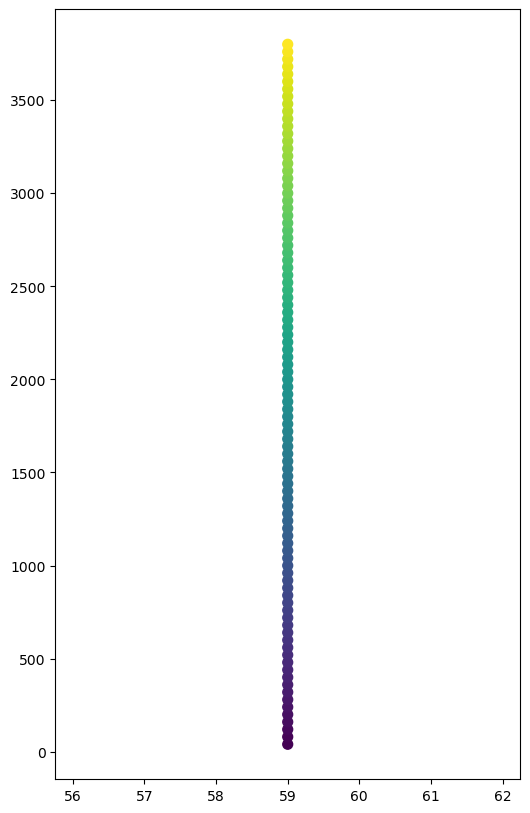

In [6]:
if nwb and nwb.electrodes:
    try:
        electrodes_df = nwb.electrodes.to_dataframe()

        plt.figure(figsize=(6, 10))
        # No seaborn theme for scatter of positions
        sns.reset_orig()

        # Use electrode IDs for labels if available
        labels = electrodes_df.index

        scatter = plt.scatter(
            electrodes_df['probe_horizontal_position'],
            electrodes_df['probe_vertical_position'],
            c=electrodes_df['probe_vertical_position'], # Color by depth
            cmap='viridis',
            s=50 # Marker size
        )

        # Add labels (electrode IDs) to each point
        for i, txt in enumerate(labels):
            plt.annotate(txt, (electrodes_df['probe_horizontal_position'][i], electrodes_df['probe_vertical_position'][i]), fontsize=8, alpha=0.7)

        plt.colorbar(scatter, label='Vertical Position (microns)')
        plt.xlabel('Horizontal Position (microns)')
        plt.ylabel('Vertical Position (microns)')
        plt.title('Electrode Locations on Probe 0')
        plt.gca().set_aspect('equal', adjustable='box') # Make aspect ratio equal
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

        # Restore seaborn theme if desired for subsequent plots
        sns.set_theme()

    except Exception as e:
        print(f"\nError plotting electrode locations: {e}")
        import traceback
        traceback.print_exc()
        # Ensure theme is restored even if error occurs
        sns.set_theme()
else:
    print("NWB file or electrodes table not available for visualization.")

## 6. Summary and Future Directions

This notebook demonstrated how to access Dandiset 000690 using the DANDI API, load a specific NWB file containing LFP data (`sub-692072/sub-692072_ses-1298465622_probe-0_ecephys.nwb`), inspect its contents, and visualize a subset of the LFP signals and electrode locations.

**Findings:**
* We successfully connected to the DANDI archive and retrieved metadata and asset lists for Dandiset 000690.
* We loaded LFP data and electrode information from a remote NWB file without downloading the entire file.
* Basic visualization showed LFP traces from selected channels over a short time window and the spatial layout of the electrodes on the probe.

**Future Directions:**
* Analyze LFP data across different stimulus conditions (requires loading stimulus information, often from a different linked NWB file or fields within the same file if available).
* Explore data from other probes or subjects within the Dandiset.
* Perform spectral analysis (e.g., power spectral density) on the LFP signals.
* Investigate correlations or coherence between channels.
* If spike sorting data (`Units`) is available in other files or processing modules, analyze spike trains and their relationship to LFP or stimuli.
* Load and analyze associated imaging data if present in `_image.nwb` files.

Remember to consult the Dandiset documentation and NWB file structure for more details on available data and metadata fields relevant to your research questions.

---
End of Notebook

In [7]:
# Final cleanup (optional, closes the remote file handles)
if io:
    try:
        io.close()
        print("\nNWB IO closed.")
    except Exception as e:
        print(f"Error closing NWB IO: {e}")
# H5py file is managed by NWBHDF5IO, but remfile might need explicit closing if needed,
# however, it's often handled by garbage collection or context managers.
# if remote_file:
#     try:
#         remote_file.close()
#         print("Remote file handle closed.")
#     except Exception as e:
#         print(f"Error closing remote file handle: {e}")


NWB IO closed.
